# **Análise do Dataset Movie Lens Small**

# Informações Gerais

## Conhecendo o dataset


Trata-se do conjunto de dados [Movie Lens Small](https://files.grouplens.org/datasets/movielens/ml-latest-small.zip), contendo classificação de filmes do serviço de recomendação [movielens](http://movielens.org).

### Informações do [README](data/ml-latest-small/README.txt) do dataset

O dataset contém **100.836 avaliações** e **3.683 *rótulos*** para **9.742 filmes**. Os dados foram criados por **610 usuários** entre 29/03/1996 e 24/09/2018. Cada usuário avaliou pelo menos 20 filmes.

Os arquivos estão em formato *CSV*, com uma única linha de cabeçalho. Colunas que contenham vírgula estão escapadas com aspas duplas. Codificação é UTF-8.

- **User Ids**: São consistentes entre os arquivos `ratigns.csv` e `tags.csv` (mesmo *id* se refere a um mesmo usuário nestes dois arquivos)
- **Movie Ids**: Apenas filmes com ao menos uma avaliação ou *rótulo* estão inclusos no dataset. Ids são consistentes entre os arquivos `ratings.csv`, `tags.csv`, `movies.csv` e `links.csv`

#### `ratings.csv`
> 100.836 avaliações

Cada linha do arquivo representa uma avaliação de um filme por um usuário, no seguinte formato:

    userId,movieId,rating,timestamp

As avaliações estão em uma escala de *5 estrelas*, com incrementos de *0,5 estrelas* (0,5 - 5.0). *Timestamp* é uma valor em [Unix time](https://en.wikipedia.org/wiki/Unix_time).

#### `tags.csv`
> 3.683 *rótulos*

Cada linha do arquivo representa um *rótulo* atribuído a um filme por um usuário, no seguinte formato:

    userId,movieId,tag,timestamp

*Rótulos* são metadados dos filmes, formadas em geral por palavras únicas ou frases curtas. *Timestamp* é uma valor em [Unix time](https://en.wikipedia.org/wiki/Unix_time).

#### `movies.csv`
> 9.742 filmes

Cada linha do arquivo representa um filme, no seguinte formato:

    movieId,title,genres

Os títulos dos filmes podem conter erros e inconsistências. O ano de lançamento está incluso entre parêntesis.

Os gêneros estão em uma lista separadas por pipe (`|`), e são selecionados dos seguintes valores:

* Action
* Adventure
* Animation
* Children's
* Comedy
* Crime
* Documentary
* Drama
* Fantasy
* Film-Noir
* Horror
* Musical
* Mystery
* Romance
* Sci-Fi
* Thriller
* War
* Western
* (no genres listed)

#### `links.csv`
> 9.742 *links*

Cada linha do arquivo representa um filme, contendo *links* para outras fontes de dados de filmes, no seguinte formato:

    movieId,imdbId,tmdbId

*movieId* é um identificador dos filmes usado pelo [movielens](https://movielens.org)<br />
*imdbId* é um identificador dos filmes usado pelo [IMDb](http://www.imdb.com)<br />
*tmdbId* é um identificador dos filmes usado pelo [TMDB](https://www.themoviedb.org)

### Diagrama dos Dados

A partir da especificação dos dados, podemos traçar um diagrama para melhor visualizar a relação entre as diferentes tabelas. Isto nos ajudará no momento de validar e limpar os dados carregados.

![](https://github.com/dieguim-ifsp-posCD/D1AED/blob/evaluation-01/avaliacoes/20210513-avaliacao01/recursos/20210524-diagrama_dados.png?raw=1)

## Importação do Dataset

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import PercentFormatter

# Define tema dos gráficos para o padrão do seaborn
sns.set_theme()

In [2]:
DATAPATH = 'https://raw.githubusercontent.com/dieguim-ifsp-posCD/D1AED/evaluation-01/avaliacoes/20210513-avaliacao01/data/ml-latest-small'

ratings_df = pd.read_csv(f'{DATAPATH}/ratings.csv')
tags_df    = pd.read_csv(f'{DATAPATH}/tags.csv')
movies_df  = pd.read_csv(f'{DATAPATH}/movies.csv')
links_df   = pd.read_csv(f'{DATAPATH}/links.csv')

In [3]:
ratings_df.head(3)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224


In [4]:
tags_df.head(3)

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992


In [5]:
movies_df.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [6]:
links_df.head(3)

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0


## Consistência dos dados

### Dataset *Ratings*

#### Linhas e Colunas

In [7]:
# Verificação do número de linhas e lista de colunas, de acordo com a especificação do dataset
linhas_esperadas = 100836
colunas_esperadas = ['userId', 'movieId', 'rating', 'timestamp']

(num_linhas, num_colunas) = ratings_df.shape
lista_colunas = list(ratings_df.columns)

assert num_linhas == linhas_esperadas, 'Número de linhas não condiz com o esperado'
assert num_colunas == len(colunas_esperadas), 'Número de colunas não condiz com o esperado'
assert lista_colunas == colunas_esperadas, 'Colunas inconsistentes com o esperado'

print(f'Número de linhas `{num_linhas}` e lista de colunas `{lista_colunas}` do DataFrame Ratings estão corretos')

Número de linhas `100836` e lista de colunas `['userId', 'movieId', 'rating', 'timestamp']` do DataFrame Ratings estão corretos


In [8]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


Não há nenhum valor nulo para nenhuma das colunas do DataFrame

O tipo de todas as colunas é condizente com o que esperamos:
- **userId** e **movieId** são *inteiros*, como esperado para Ids
- **rating** é *real*, conforme esperado, pois as avaliações estão em um intervalo de 0,5 estrelas
- **timestamp** é *inteiro*, como esperado para um valor de *Unix time*

#### Atributo *userId*

In [9]:
# Verificação da quantidade de usuários únicos
# De acordo com especificação, todos usuários avaliaram pelo menos 20 filmes, logo todos devem estar presentes no DataFrame
usuarios_esperados = 610

num_usuarios = len(ratings_df.userId.unique())

assert num_usuarios == usuarios_esperados, 'Número de usuários não condiz com o esperado'

print(f'Número de usuários `{num_usuarios}` do DataFrame está correto')
print(f'{(num_usuarios/usuarios_esperados * 100):.2f}% dos usuários realizaram avaliação de algum filme')

Número de usuários `610` do DataFrame está correto
100.00% dos usuários realizaram avaliação de algum filme


#### Atributo *movieId*

In [10]:
# Verificação quantidade de filmes avaliados
# A especificação não diz que todos os filmes possuem avaliação (alguns filmes podem possuir apenas rótulos),
# portanto iremos avaliar apenas se o número de ids de filmes é menor do que o total do dataset
filmes_maximo = 9742

num_filmes = len(ratings_df.movieId.unique())

assert num_filmes <= filmes_maximo, 'Número de filmes é maior do que o máximo esperado'

print(f'Número de filmes `{num_filmes}` no DataFrame está dentro do limite máximo esperado')
print(f'{(num_filmes/filmes_maximo * 100):.2f}% dos filmes receberam pelo menos uma avaliação')

Número de filmes `9724` no DataFrame está dentro do limite máximo esperado
99.82% dos filmes receberam pelo menos uma avaliação


#### Atributo *rating*

In [11]:
# Verificação das avaliações
# De acordo com a especificação, as notas estão no intervalo [0.5, 5.0], com saltos de 0.5
avaliacoes_esperadas = np.arange(0.5, 5.1, 0.5) # Colocamos um valor ligeiramente maior que 5.0 como 'stop' para que o '5.0' seja incluido

lista_avaliacoes = ratings_df.rating.unique()

assert set(lista_avaliacoes).issubset(set(avaliacoes_esperadas)), 'Lista de avaliações possui valores diferentes do esperado'

print(f'Avaliações `{lista_avaliacoes}` dos registros do DataFrame estão dentro do conjunto esperado')

Avaliações `[4.  5.  3.  2.  1.  4.5 3.5 2.5 0.5 1.5]` dos registros do DataFrame estão dentro do conjunto esperado


#### Atributo *timestamp*

In [12]:
# Verificação do intervalo de datas
# De acordo com a especificação, as avaliações devem estar entre 29/03/1996 e 24/09/2018
data_minima = pd.to_datetime('1996-03-29 00:00:00')
data_maxima = pd.to_datetime('2018-09-24 23:59:59')

ratings_data_minima = pd.to_datetime(min(ratings_df.timestamp), unit='s', origin='unix')
ratings_data_maxima = pd.to_datetime(max(ratings_df.timestamp), unit='s', origin='unix')

assert ratings_data_minima > data_minima, 'Existe data mais antiga em ratings do que o esperado'
assert ratings_data_maxima < data_maxima, 'Existe data mais recente em ratings do que o esperado'

print(f'Datas de avaliação entre {ratings_data_minima} e {ratings_data_maxima} estão dentro do esperado')

Datas de avaliação entre 1996-03-29 18:36:55 e 2018-09-24 14:27:30 estão dentro do esperado


#### Duplicações

In [13]:
# Verificando se um mesmo usuário realizou mais de uma avaliação de um determinado filme
avaliacoes_duplicadas = ratings_df[ratings_df.duplicated(subset=['userId', 'movieId'])]

assert len(avaliacoes_duplicadas) == 0, 'Existem avaliações duplicadas'

print('Nenhuma avaliação duplicada (mesmo usuário avaliando um mesmo filme mais de uma vez) no dataset')

Nenhuma avaliação duplicada (mesmo usuário avaliando um mesmo filme mais de uma vez) no dataset


### Dataset *Tags*

#### Linhas e Colunas

In [14]:
# Verificação do número de linhas e lista de colunas, de acordo com a especificação do dataset
linhas_esperadas = 3683
colunas_esperadas = ['userId', 'movieId', 'tag', 'timestamp']

(num_linhas, num_colunas) = tags_df.shape
lista_colunas = list(tags_df.columns)

assert num_linhas == linhas_esperadas, 'Número de linhas não condiz com o esperado'
assert num_colunas == len(colunas_esperadas), 'Número de colunas não condiz com o esperado'
assert lista_colunas == colunas_esperadas, 'Colunas inconsistentes com o esperado'

print(f'Número de linhas `{num_linhas}` e lista de colunas `{lista_colunas}` do DataFrame Tags estão corretos')

Número de linhas `3683` e lista de colunas `['userId', 'movieId', 'tag', 'timestamp']` do DataFrame Tags estão corretos


In [15]:
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


Não há nenhum valor nulo para nenhuma das colunas do DataFrame

O tipo de todas as colunas é condizente com o que esperamos:
- **userId** e **movieId** são *inteiros*, como esperado para Ids
- **tags** é *object*, conforme esperado, pois as tags são *strings*
- **timestamp** é *inteiro*, como esperado para um valor de *Unix time*

#### Atributo *userId*

In [16]:
# Verificação da quantidade de usuários únicos
# A especificação não diz que todos os usuários rotularam filmes,
# portanto podemos avaliar apenas se o número de usuários é menor que o máximo do dataset
usuarios_maximo = 610

num_usuarios = len(tags_df.userId.unique())

assert num_usuarios <= usuarios_esperados, 'Número de usuários é maior que o máximo esperado'

print(f'Número de usuários `{num_usuarios}` do DataFrame está dentro do limite máximo esperado')
print(f'{(num_usuarios/usuarios_maximo * 100):.2f}% dos usuários rotularam algum filme')

Número de usuários `58` do DataFrame está dentro do limite máximo esperado
9.51% dos usuários rotularam algum filme


Aqui já podemos notar que o número de usuários presentes no DataFrame de *tags* é consideravelmente pequeno.

#### Atributo *movieId*

In [17]:
# Verificação quantidade de filmes avaliados
# A especificação não diz que todos os filmes possuem rótulos,
# portanto iremos avaliar apenas se o número de ids de filmes é menor do que o total do dataset
filmes_maximo = 9742

num_filmes = len(tags_df.movieId.unique())

assert num_filmes <= filmes_maximo, 'Número de filmes é maior do que o máximo esperado'

print(f'Número de filmes `{num_filmes}` no DataFrame está dentro do limite máximo esperado')
print(f'{(num_filmes/filmes_maximo * 100):.2f}% dos filmes receberam pelo menos um rótulo')

Número de filmes `1572` no DataFrame está dentro do limite máximo esperado
16.14% dos filmes receberam pelo menos um rótulo


O número de filmes *rotulados* também é consideravelmente pequeno.

#### Atributo *tags*

In [18]:
# Verificação dos rótulos
# De acordo com a especificação, os rótulos em geral são palavras únicas ou frases curtas

# Separa o campo tags em uma lista de palavras
lista_palavras = tags_df.tag.str.split()

# Verifica quantos elementos contém cada lista (ou seja, quantas palavras o rótulo possui) e agrega os valores
palavras_tag = lista_palavras.apply(len).value_counts().to_frame().reset_index()
palavras_tag.columns = ['Palavras na Tag', 'Número de Registros']
palavras_tag['% Registros'] = round((palavras_tag['Número de Registros'] / palavras_tag['Número de Registros'].sum())*100,1)
palavras_tag['%Registros Acumulados'] = palavras_tag['% Registros'].cumsum()

palavras_tag

,Palavras na Tag,Número de Registros,% Registros,%Registros Acumulados
0,1,2282,62.0,62.0
1,2,1057,28.7,90.7
2,3,275,7.5,98.2
3,4,43,1.2,99.4
4,5,16,0.4,99.8
5,7,4,0.1,99.9
6,6,3,0.1,100.0
7,8,1,0.0,100.0
8,10,1,0.0,100.0
9,16,1,0.0,100.0


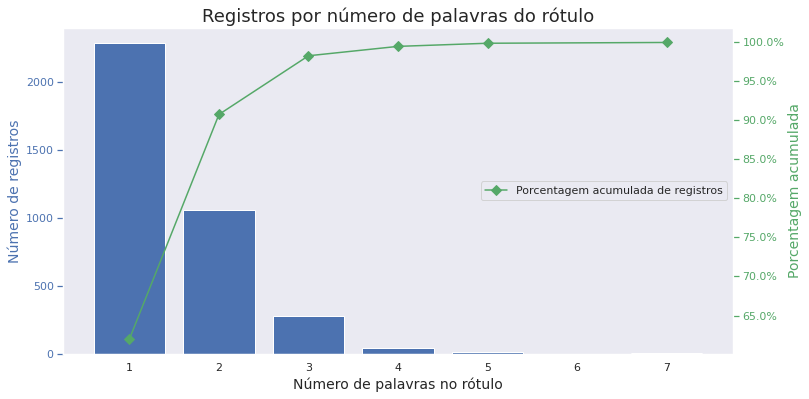

In [19]:
def Pareto(df, Type, Count, CumPercent):
    # Cria o barplot e define os dados os eixos, a cor das barras, titulo do gráfico
    fig, ax = plt.subplots(figsize=(12,6))
    ax.bar(df[Type], df[Count])
    ax.set_title("Registros por número de palavras do rótulo", fontsize=18)

    # Eixo secundário
    ax2 = ax.twinx()

    # Cria a Curva de Pareto no eixo secundário
    ax2.plot(df[Type], df[CumPercent], color="g", marker="D", ms=7, label='Porcentagem acumulada de registros')
    ax2.yaxis.set_major_formatter(PercentFormatter())

    # Configurações dos eixos
    ax.set_xlabel("Número de palavras no rótulo", fontsize=14)
    
    ax.tick_params(axis="y", colors="b")
    ax.set_ylabel("Número de registros", color="b", fontsize=14)
    ax.grid(False)
    
    ax2.tick_params(axis="y", colors="g")
    ax2.set_ylabel("Porcentagem acumulada", color="g", fontsize=14)
    ax2.grid(False)

    # Finalmente mostra o grafico definido acima
    plt.legend(loc='center right') # para mostrar a legenda
    plt.show()

Pareto(palavras_tag[:6], 'Palavras na Tag', 'Número de Registros', '%Registros Acumulados')

Aqui é uma avaliação um pouco subjetiva, mas como visto no gráfico de Pareto, a maioria dos registros de rótulos (mais de 98%) possui até 3 palavras, o que cumpre com a especificação de um *rótulo*. 

É possível que os *outliers* (que contenham *muitas* palavras) não sejam termos que cumpram a função de *rótulo*.

#### Atributo *timestamp*

In [20]:
# Verificação do intervalo de datas
# De acordo com a especificação, os rótulos devem estar entre 29/03/1996 e 24/09/2018
data_minima = pd.to_datetime('1996-03-29 00:00:00')
data_maxima = pd.to_datetime('2018-09-24 23:59:59')

tags_data_minima = pd.to_datetime(min(tags_df.timestamp), unit='s', origin='unix')
tags_data_maxima = pd.to_datetime(max(tags_df.timestamp), unit='s', origin='unix')

assert tags_data_minima > data_minima, 'Existe data mais antiga em tags do que o esperado'
assert tags_data_maxima < data_maxima, 'Existe data mais recente em tags do que o esperado'

print(f'Datas dos rótulos entre {tags_data_minima} e {tags_data_maxima} estão dentro do esperado')

Datas dos rótulos entre 2006-01-13 19:09:12 e 2018-09-16 11:50:03 estão dentro do esperado


O registro mais antigo de rótulo é do ano de 2006, ou seja, uma década após os primeiros registros de avaliações.

#### Duplicações

In [21]:
# Verificando se um mesmo usuário atribuiu um determinado rótulo mais de uma vez para um determinado filme)]
rotulos_duplicados = tags_df[tags_df.duplicated(subset=['userId', 'movieId', 'tag'])]

assert len(rotulos_duplicados) == 0, 'Existem rótulos duplicados'

print('Nenhuma rótulo duplicado no dataset')

Nenhuma rótulo duplicado no dataset


### Dataset *Movies*

#### Linhas e Colunas

In [22]:
# Verificação do número de linhas e lista de colunas, de acordo com a especificação do dataset
linhas_esperadas = 9742
colunas_esperadas = ['movieId', 'title', 'genres']

(num_linhas, num_colunas) = movies_df.shape
lista_colunas = list(movies_df.columns)

assert num_linhas == linhas_esperadas, 'Número de linhas não condiz com o esperado'
assert num_colunas == len(colunas_esperadas), 'Número de colunas não condiz com o esperado'
assert lista_colunas == colunas_esperadas, 'Colunas inconsistentes com o esperado'

print(f'Número de linhas `{num_linhas}` e lista de colunas `{lista_colunas}` do DataFrame Movies estão corretos')

Número de linhas `9742` e lista de colunas `['movieId', 'title', 'genres']` do DataFrame Movies estão corretos


In [23]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


Não há nenhum valor nulo para nenhuma das colunas do DataFrame

O tipo de todas as colunas é condizente com o que esperamos:
- **movieId** é *inteiros*, como esperado para Ids
- **title** é *object*, conforme esperado, pois os títulos são *strings*
- **genres** é *object*, conforme esperado, pois os gêneros são *strings*

#### Atributo *movieId*

In [24]:
# Verificação quantidade de filmes
filmes_esperados = 9742

num_filmes = len(movies_df.movieId.unique())

assert num_filmes == filmes_esperados, 'Número de filmes não condiz com o esperado'

print(f'Número de filmes `{num_filmes}` no DataFrame está correto de acordo com a especificação')

Número de filmes `9742` no DataFrame está correto de acordo com a especificação


#### Atributo *title*

In [25]:
# Verificação dos títulos
# Como títulos são strings, vamos verificar apenas se possuem alguma repetição ou valor vazio

duplicados = movies_df[movies_df.title.duplicated()]
vazios = movies_df[movies_df.title == '']

print(f'Existe `{len(duplicados)}` filmes com títulos duplicados. E `{len(vazios)}` com título vazio')

Existe `5` filmes com títulos duplicados. E `0` com título vazio


#### Atributo *genres*

In [26]:
generos_esperados = [
    "Action", "Adventure", "Animation", "Children's", "Comedy", "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir",
    "Horror", "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western", "(no genres listed)"
]

# Separa o campo genres em uma lista de gêneros
lista_generos = movies_df.genres.str.split("|")

# Transforma a lista de listas de gêneros em uma só Series com todos os valores
# https://towardsdatascience.com/dealing-with-list-values-in-pandas-dataframes-a177e534f173
todos_generos = pd.Series([x for _list in lista_generos for x in _list])

# Vamos verificar se os gêneros no nosso dataset estão todos dentro da lista esperada
try:
    assert set(todos_generos.unique()).issubset(generos_esperados), 'Existe gêneros que não são esperados'
except Exception as e:
    print(type(e), e)
    
# Quais gêneros não são esperados?
print('Gêneros no dataset diferentes do esperado:', np.setdiff1d(todos_generos, generos_esperados))

<class 'AssertionError'> Existe gêneros que não são esperados
Gêneros no dataset diferentes do esperado: ['Children' 'IMAX']


Existem dois gêneros presentes no *dataset* que não são esperados, de acordo com a especificação: **Children** e **IMAX**

No caso de **Children**, parece que houve um erro na especificação do *dataset*. Vamos sustituir o valor esperado de **Children's** para **Children**

In [27]:
try:
    generos_esperados[generos_esperados.index("Children's")] = "Children"
except:
    print("Children's já foi substituido. Continuando...")
    
print('Gêneros no dataset diferentes do esperado:', np.setdiff1d(todos_generos,generos_esperados))

Gêneros no dataset diferentes do esperado: ['IMAX']


Agora só temos o gênero **IMAX** que não está especificiado.

Vamos ver quantas vezes ele ocorre

In [28]:
(todos_generos == 'IMAX').sum()

158

### Dataset *Links*

Os atributos deste dataset não nos parece necessário para as análises desejadas. Desta forma, iremos desconsiderá-lo a partir de agora

### Relações entre Datasets

#### Atributo *userId* em `ratings` e `tags`

In [29]:
# Verificar se os usuários de tags são um subconjunto dos usuários de ratings,
# uma vez que este possui a lista completa de usuários

usuarios_ratings = ratings_df.userId.unique()
usuarios_tags = tags_df.userId.unique()

assert set(usuarios_tags).issubset(set(usuarios_ratings)), 'Existem usuários em `tags` que não estão presentes em `ratings`'

print(f'Os {len(usuarios_tags)} usuários em `tags` são um subconjunto dos {len(usuarios_ratings)} usuários em `ratings`')

Os 58 usuários em `tags` são um subconjunto dos 610 usuários em `ratings`


#### Atributo *movieId* em `ratings`, `tags` e `movies`

In [30]:
# Verificar se os Ids de filmes em ratings e tags são um subconjunto dos filmes em movies

filmes_ratings = ratings_df.movieId.unique()
filmes_tags = tags_df.movieId.unique()
filmes_movies = movies_df.movieId.unique()

assert set(filmes_ratings).issubset(set(filmes_movies)), 'Existem filmes em `ratings` que não estão presentes em `movies`'
assert set(filmes_tags).issubset(set(filmes_movies)), 'Existem filmes em `tags` que não estão presentes em `movies`'

print(f'Os {len(filmes_ratings)} filmes em `ratings` e os {len(filmes_tags)} em `tags` são um subconjunto dos {len(filmes_movies)} filmes do DataFrame `movies`')

Os 9724 filmes em `ratings` e os 1572 em `tags` são um subconjunto dos 9742 filmes do DataFrame `movies`


In [31]:
# Verificar se todos os filmes em movies receberam ao menos uma avaliação ou rótulo

assert set(np.concatenate((filmes_ratings, filmes_tags))) == set(movies_df.movieId), 'Conjunto de movieId nos DataFrames `ratings` e `tags` difere dos Ids no DataFrame `movies`'

print('O conjunto de movieId nos DataFrames `ratings` e `tags` é o mesmo dos filmes no DataFrame `movies`')

O conjunto de movieId nos DataFrames `ratings` e `tags` é o mesmo dos filmes no DataFrame `movies`


# Pré-processamento

## Conversão do timestamp em *ratings* e *tags* para `datetime`

In [32]:
ratings_df.timestamp = pd.to_datetime(ratings_df.timestamp, unit='s')

In [33]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,2000-07-30 18:45:03
1,1,3,4.0,2000-07-30 18:20:47
2,1,6,4.0,2000-07-30 18:37:04
3,1,47,5.0,2000-07-30 19:03:35
4,1,50,5.0,2000-07-30 18:48:51


In [34]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   userId     100836 non-null  int64         
 1   movieId    100836 non-null  int64         
 2   rating     100836 non-null  float64       
 3   timestamp  100836 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 3.1 MB


In [35]:
tags_df.timestamp = pd.to_datetime(tags_df.timestamp, unit='s')

In [36]:
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   userId     3683 non-null   int64         
 1   movieId    3683 non-null   int64         
 2   tag        3683 non-null   object        
 3   timestamp  3683 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 115.2+ KB


## Rótulos com muitas palavras

In [37]:
tags_df[lista_palavras.apply(len) > 4]

,userId,movieId,tag,timestamp
412,106,4896,Everything you want is here,2016-07-03 17:29:04
485,161,52287,Something for everyone in this one... saw it w...,2007-04-13 21:14:21
587,318,48698,the catholic church is the most corrupt organi...,2010-06-08 14:09:49
621,319,364,Oscar (Best Music - Original Score),2016-04-22 19:05:19
739,424,608,based on a true story,2016-03-13 20:28:02
840,424,3186,based on a true story,2016-03-13 05:13:22
1112,474,457,based on a TV show,2006-01-20 19:18:37
1164,474,648,based on a TV show,2006-01-24 21:19:44
1181,474,818,based on a TV show,2006-01-16 01:46:36
1201,474,912,start of a beautiful friendship,2006-01-14 01:31:59


As tags com mais de 4 palavras serão removidas da análise

## Títulos duplicados

In [38]:
# Nome dos filmes repetidos
title_filmes_duplicados = duplicados['title']

# Df com as informações dos filmes repetidos com os dados do "movies_df"
lista_filmes_duplicados = movies_df.query('title in @title_filmes_duplicados').copy()

# Id dos filmes repetidos
movieId_filmes_duplicados = lista_filmes_duplicados['movieId'].values

# Quantidade de Notas atribuidas aos movieId com dados do "ratings_df"
lista_filmes_duplicados.set_index('movieId', inplace = True)
lista_filmes_duplicados['Ratings_count'] = ratings_df.query('movieId in @movieId_filmes_duplicados').movieId.value_counts().values
lista_filmes_duplicados.sort_values(by =['title'])

,title,genres,Ratings_count
movieId,,,
6003,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Thriller,15
144606,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Romance|Thriller,1
838,Emma (1996),Comedy|Drama|Romance,50
26958,Emma (1996),Romance,4
32600,Eros (2004),Drama,2
147002,Eros (2004),Drama|Romance,1
2851,Saturn 3 (1980),Adventure|Sci-Fi|Thriller,30
168358,Saturn 3 (1980),Sci-Fi|Thriller,1
34048,War of the Worlds (2005),Action|Adventure|Sci-Fi|Thriller,1


Para evitar problemas de separação de dados, os ID's serão unificados conforme relação abaixo

    Confessions of a Dangerous Mind (2002) - movieId: 6003 (old: 144606)
    Emma (1996) - movieId: 838 (old: 26958)
    Eros (2004) - movieId: 32600 (old: 147002)
    Saturn 3 (1980) - movieId: 2851 (old: 168358)
    War of the Worlds (2005) - movieId: 34048 (old:64997)

In [39]:
# Lista movieId Excluidos
movie_id_excluidos = [144606, 26958, 147002, 168358, 64997]

# Função de conversão
def conversao_movieId(num):
    if num == 144606:
        return 6003
    elif num == 26958:
        return 838
    elif num == 147002:
        return 32600
    elif num == 168358:
        return 2851
    elif num == 64997:
        return 34048
    else:
        return num

# Deletar id duplicados - movies_df
movies_df.drop((movies_df.query('movieId in @movie_id_excluidos').index), inplace = True, axis = 0)
duplicados_movies = len(movies_df[movies_df.title.duplicated()])

# Conversão de id - ratings_df
ratings_df['movieId'] = ratings_df['movieId'].map(conversao_movieId)
duplicados_ratings = len(ratings_df.query('movieId in @movie_id_excluidos'))

# Conversão tags_df
tags_df['movieId'] = tags_df['movieId'].map(conversao_movieId)
duplicados_tags = len(ratings_df.query('movieId in @movie_id_excluidos'))

# Verificação dos movie_id excluidos
print(f'Exitem {duplicados_movies} filmes com o movieId excluido no movies_df')
print(f'Exitem {duplicados_ratings} filmes com o movieId excluido no ratings_df')
print(f'Exitem {duplicados_tags} filmes com o movieId excluido no tags_df')

Exitem 0 filmes com o movieId excluido no movies_df
Exitem 0 filmes com o movieId excluido no ratings_df
Exitem 0 filmes com o movieId excluido no tags_df


## Gêneros não especificados
### IMAX

In [40]:
# Separar os generos por colunas
generos = movies_df['genres'].str.get_dummies()

# Juntar informações do movies_df com os generos separados por coluna
movies_df_generos = pd.concat([movies_df, generos], axis=1)
movies_df_generos.drop('genres', axis=1, inplace=True)

print(f'Quantidade de filmes com genero IMAX: {movies_df_generos.query("IMAX == 1").shape[0]}\n\n')
movies_df_generos.head()

Quantidade de filmes com genero IMAX: 158




,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


Embora o genero IMAX não esteja listado na documentação do dataset, essa informação não altera as análises. Dessa forma o genero IMAX será tratado como um genero válido

## Decisões

- **Quantidade de dados**: Todos os *datasets* possuem todas as colunas completas.
- **Tipo de dados**: Conversão do atributo *timestamp* para `datetime`, todos os demais dados estão com o formato correto.
- **Outliers**:
  - Tag: Optou-se por remover as *tags* com mais de 4 palavras, uma vez que não cumprem o propósito de rótulo
- **Tratamento dos dados**:
  - Filmes Duplicados: 5 filmes estavam com o título duplicado - Optou-se por unificar os id para evitar problemas de análises
  - Gêneros: O gênero *IMAX* não constava na documentação do arquivo, optou-se por manter essa informação, como um gênero válido

# Análise Exploratória

## 1 - Existe alguma correlação entre o ano de lançamento do filme e sua avaliação média (média de ratings)?

In [41]:
# Separar o ano do titulo
ano_movies = movies_df.copy()
ano_movies['ano'] = ano_movies['title'].str.split('(').str.get(-1).str.split(')').str.get(0)

# Converter ano para int
ano_movies['ano'] = pd.to_numeric(ano_movies['ano'], errors='coerce')

# Verificar tipo de dados
ano_movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9737 entries, 0 to 9741
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9737 non-null   int64  
 1   title    9737 non-null   object 
 2   genres   9737 non-null   object 
 3   ano      9724 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 380.4+ KB


In [42]:
# Filmes sem ano definido
filmes_sem_ano = ano_movies[ano_movies['ano'].isna()]
print(f'Existem {filmes_sem_ano.shape[0]} filmes sem a informação do ano\n\n')
filmes_sem_ano

Existem 13 filmes sem a informação do ano




,movieId,title,genres,ano
6059,40697,Babylon 5,Sci-Fi,NaN
9031,140956,Ready Player One,Action|Sci-Fi|Thriller,NaN
9091,143410,Hyena Road,(no genres listed),NaN
9138,147250,The Adventures of Sherlock Holmes and Doctor W...,(no genres listed),NaN
9179,149334,Nocturnal Animals,Drama|Thriller,NaN
9259,156605,Paterson,(no genres listed),NaN
9367,162414,Moonlight,Drama,NaN
9448,167570,The OA,(no genres listed),NaN
9514,171495,Cosmos,(no genres listed),NaN
9515,171631,Maria Bamford: Old Baby,(no genres listed),NaN


In [43]:
# Juntando o ano com as notas
rating_ano_movies = ratings_df.copy()
rating_ano_movies = rating_ano_movies[['movieId', 'rating']].merge(ano_movies[['movieId', 'ano']], on = 'movieId', how = 'left')

In [44]:
# Criando um DF com a media das notas por ano
rating_medio_por_ano = rating_ano_movies[['ano', 'rating']].groupby('ano').mean()
rating_medio_por_ano['count'] = rating_ano_movies[['ano', 'rating']].groupby('ano').count()
rating_medio_por_ano = rating_medio_por_ano.rename_axis('ano').reset_index()
rating_medio_por_ano

,ano,rating,count
0,1902.0,3.500000,5
1,1903.0,2.500000,2
2,1908.0,4.000000,1
3,1915.0,2.000000,1
4,1916.0,3.600000,5
...,...,...,...
101,2014.0,3.512879,1320
102,2015.0,3.410386,1088
103,2016.0,3.387261,785
104,2017.0,3.578091,461


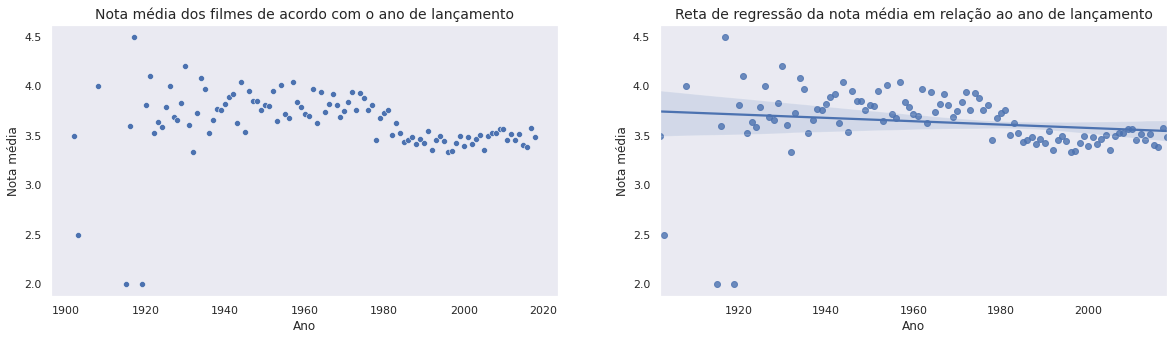

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(20,5))

# Gráfico de dispersão
sns.scatterplot(x = 'ano', y = 'rating', data = rating_medio_por_ano, ax=axs[0])
axs[0].set(ylabel = 'Nota média', xlabel = 'Ano')
axs[0].set_title('Nota média dos filmes de acordo com o ano de lançamento', fontsize = 14)
axs[0].grid(False)

# Reta de regrassão
sns.regplot(x = 'ano', y = 'rating', data = rating_medio_por_ano, ax=axs[1])
axs[1].set(ylabel = 'Nota média', xlabel = 'Ano')
axs[1].set_title('Reta de regressão da nota média em relação ao ano de lançamento', fontsize = 14)
axs[1].grid(False)

plt.show()

O gráfico da nota média dos filmes por ano de lançamento não indica uma tendência ao longo do tempo. A reta de regressão apresenta uma leve inclinação negativa.

In [46]:
# Coeficiente de Correlação
rating_medio_por_ano.corr().round(3)

,ano,rating,count
ano,1.000,-0.158,0.667
rating,-0.158,1.000,-0.289
count,0.667,-0.289,1.000


Segundo a [Tabela do Coeficiente de Correlação de Pearson](https://pt.wikipedia.org/wiki/Coeficiente_de_correla%C3%A7%C3%A3o_de_Pearson), a correlação entre o ano de lançamento do filme e sua nota média é de **-0,158**, podendo ser considerada desprezível.

## 2 - Qual o grupo mais disperso, o de usuários que avaliaram ou o de usuários que rotularam filmes?


[OFF] Não sei se entendi a pergunta, vou levar em conta a dispersão da quantidade de vezes que um usuário avaliou um filme ou tageou ele

In [64]:
# Criando os DF de userId pela quantidade de vezes que o usuário avaliou um filme
userId_quantidade_de_ratings = ratings_df[['userId','movieId']].groupby('userId').count()

# Criando os DF de userId pela quantidade de vezes que o usuário colocou uma tag no filme
userId_quantidade_de_tags = tags_df[['userId','movieId']].groupby('userId').count()

# DF comparando valores de TAGS e RATINGS

# Count = Quantidade de usuários que tiveram "interação" (seja avaliação ou tag)
# Mean  = Média de inserções no dataframe
# STD   = Desvio Padrão de inserções no dataframe
# CV    = Coeficiente de Variação (STD / Mean)

comparação_tags_e_ratings = pd.DataFrame({'Count': [userId_quantidade_de_tags.shape[0], userId_quantidade_de_ratings.shape[0]],
                                          'Mean': [round(userId_quantidade_de_tags.mean()[0],2), round(userId_quantidade_de_ratings.mean()[0],2)],
                                          'STD'  : [round(userId_quantidade_de_tags.std()[0],2), round(userId_quantidade_de_ratings.std()[0],2)] }, index = ['Tags','Ratings'])
comparação_tags_e_ratings['CV'] = round(comparação_tags_e_ratings['STD'] / comparação_tags_e_ratings['Mean'],2)
comparação_tags_e_ratings

,Count,Mean,STD,CV
Tags,58,63.5,215.12,3.39
Ratings,610,165.3,269.48,1.63


Calculando as estatísticas dos usuários para o conjunto de dados de avaliações e de rótulos

In [69]:
# Criando os DF de userId pela quantidade de vezes que o usuário avaliou um filme
userId_quantidade_de_ratings = ratings_df[['userId','movieId']].groupby('userId').count().rename(columns={'movieId': 'Ratings'})

# Criando os DF de userId pela quantidade de vezes que o usuário colocou uma tag no filme
userId_quantidade_de_tags = tags_df[['userId','movieId']].groupby('userId').count().rename(columns={'movieId': 'Tags'})

# DF comparando valores de RATINGS e TAGS
usuarios_ratings_tags = pd.concat([
    userId_quantidade_de_ratings.describe(), userId_quantidade_de_tags.describe()
], axis=1)

# Adicionando linha para o Coeficiente de Variação (CV) = std / mean
usuarios_ratings_tags.loc['CV'] = [
    usuarios_ratings_tags.loc['std', 'Ratings'] / usuarios_ratings_tags.loc['mean', 'Ratings'],
    usuarios_ratings_tags.loc['std', 'Tags'] / usuarios_ratings_tags.loc['mean', 'Tags']
]

# Adicionando linha para a Amplitude Interquartil (IQR) = 75% - 25%
usuarios_ratings_tags.loc['IQR'] = [
    usuarios_ratings_tags.loc['75%', 'Ratings'] - usuarios_ratings_tags.loc['25%', 'Ratings'],
    usuarios_ratings_tags.loc['75%', 'Tags'] - usuarios_ratings_tags.loc['25%', 'Tags']
]
usuarios_ratings_tags.round(2)

,Ratings,Tags
count,610.00,58.00
mean,165.30,63.50
std,269.48,215.12
min,20.00,1.00
25%,35.00,2.25
50%,70.50,4.00
75%,168.00,13.00
max,2698.00,1507.00
CV,1.63,3.39
IQR,133.00,10.75


Um total de 610 usuários realizaram avaliações de filmes. Em média, cada usuário realizou 165 avaliações, com um desvio padrão de 269.<br />
Um total de 58 usuários rotularam filmes. Em média, cada usuário rotulou 63 filmes, com um desvio padrão de 215.

Considerando o [Coeficiente de Variação (CV)](https://pt.wikipedia.org/wiki/Coeficiente_de_varia%C3%A7%C3%A3o), poderíamos dizer que o grupo de usuários que rotularam filmes tem um *Desvio Padrão Relativo à Média* maior do que dos usuários que avaliaram filmes, podendo indicar uma maior dispersão.

Por sua vez, a medida de [Amplitude Interquartil (IQR)](https://en.wikipedia.org/wiki/Interquartile_range) indicaria uma maior dispersão entre os usuários que realizaram avaliação.

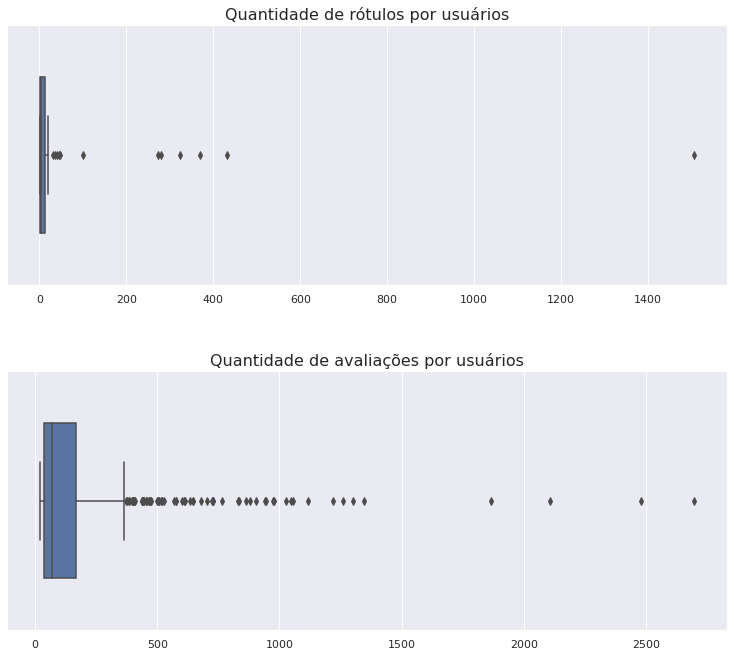

In [47]:
fig = plt.figure(figsize=(10,8))

# Boxplot Tags
eixo = fig.add_axes([0, 0.6, 1, 0.45])
eixo = sns.boxplot(x=userId_quantidade_de_tags.movieId,width = 0.6)
eixo.set(xlabel = '')
eixo.set_title('Quantidade de rótulos por usuários',fontsize = 16)

# Boxplot Ratings
eixo2 = fig.add_axes([0, 0, 1, 0.45])
eixo2 = sns.boxplot(x=userId_quantidade_de_ratings.movieId,width = 0.6)
eixo2.set(xlabel = '')
eixo2.set_title('Quantidade de avaliações por usuários',fontsize = 16)

plt.show()

  A presença de um usuário que colocou tag em mais de 1400 filmes distorce bastante os valores de média e desvio padrão desse grupo de usuários, de modo que o Coeficiente de variação é mais alto quando comparado com os usuários que avaliaram os filmes.

  A análise dos Boxplot permite ver que existem muito mais usuários que avaliam os filmes que estão fora dos limites do gráfico em relação aos usuários que colocam tag. 

  Essas duas análises permite indicar que a distribuição da quantidade de "interações" é maior nos usuários que avaliaram os filmes, ou seja, a dispersão dos valores é maior nos avaliadores em relação aos que colocam Tag




## 3 - Qual a categoria rotulada mais frequente?

In [74]:
# Juntando o DF de rótulos com a quantidade de tags usando movieId como chave
categorias_rotuladas = movies_df_generos.set_index('movieId')
categorias_rotuladas = pd.concat([categorias_rotuladas,(tags_df[['movieId','tag']].groupby('movieId').count())], axis = 1)
categorias_rotuladas.drop('title', axis = 1, inplace = True)
categorias_rotuladas.head(3)

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,tag
movieId,,,,,,,,,,,,,,,,,,,,,
1,0,0,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,3.0
2,0,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,2.0


In [82]:
# Criando Dicionário relacionando Generos com quantidade de tags
qtd_tags_por_rotulos = {}
for i in categorias_rotuladas.columns:
    qtd_tags_por_rotulos[i] = categorias_rotuladas[categorias_rotuladas[i] == 1].sum()[-1]

# Transformando Dicionário em DF
qtd_tags_por_rotulos = pd.DataFrame(qtd_tags_por_rotulos.values(), index = qtd_tags_por_rotulos.keys(), columns = ['Tags'])
qtd_tags_por_rotulos.sort_values(by='Tags', ascending= False).head(3)

,Tags
Drama,2095.0
Comedy,1154.0
Thriller,1099.0


A categoria Drama foi a mais rotulada com 2.095 Tags atribuidas

## 4 - Como estão distribuídas as avaliações ao longo do tempo?

### Número de avaliações e média das avaliações por mês

In [129]:
ratings_timestamp = ratings_df.groupby(pd.Grouper(key='timestamp',freq='M')).agg({'rating': ['mean','count']})
ratings_timestamp.columns = ['Média das avaliações', 'Número de avaliações']
ratings_timestamp.describe().round(2)

,Média das avaliações,Número de avaliações
count,267.00,271.00
mean,3.55,372.09
std,0.33,396.31
min,2.61,0.00
25%,3.37,99.00
50%,3.58,231.00
75%,3.77,516.00
max,4.62,2397.00


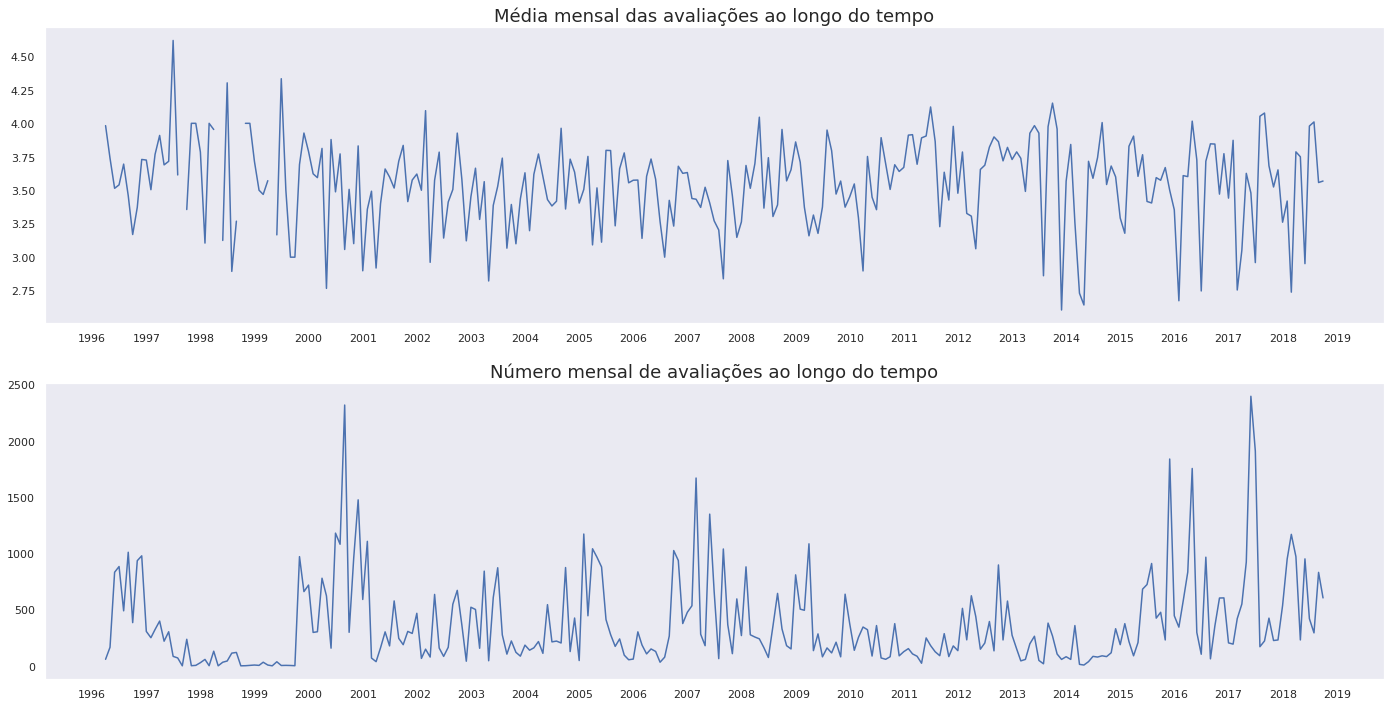

In [130]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(24,12))

# Gráfico da média das avaliações
ax1.plot(ratings_timestamp['Média das avaliações'])
ax1.set_title('Média mensal das avaliações ao longo do tempo', fontsize=18)
ax1.grid(False)

# Rótulo anual para eixo x
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.xaxis.set_major_locator(mdates.YearLocator())

# Gráfico do número de avaliações
ax2.plot(ratings_timestamp['Número de avaliações'])
ax2.set_title('Número mensal de avaliações ao longo do tempo', fontsize=18)
ax2.grid(False)

# Rótulo anual para eixo x
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax2.xaxis.set_major_locator(mdates.YearLocator())

plt.show()

Os gráficos de média e número de avaliações mensais ao longo do período **não indicam tendência ou sazonalidade**.

Mostram apenas que a **há uma grande variação a cada mês** tanto para a média quanto para o número de avaliações. Ou seja, a média das avaliações dos filmes varia de cerca de 2,6 em alguns meses até 4,6 em outros. Considerando o número de avaliações, há meses em que nenhuma avaliação foi realizada e outros em que quase 2.400 avaliações foram feitas.

### Número de avaliações e média das avaliações por ano

In [132]:
# Número de avaliações e média das avaliações por ano
ratings_timestamp = ratings_df.groupby(pd.Grouper(key='timestamp',freq='Y')).agg({'rating': ['mean','count']})
ratings_timestamp.columns = ['Média das avaliações', 'Número de avaliações']
ratings_timestamp.describe().round(2)

,Média das avaliações,Número de avaliações
count,23.00,23.00
mean,3.54,4384.17
std,0.15,2418.73
min,3.31,507.00
25%,3.43,2370.00
50%,3.51,4059.00
75%,3.65,6229.00
max,3.88,10061.00


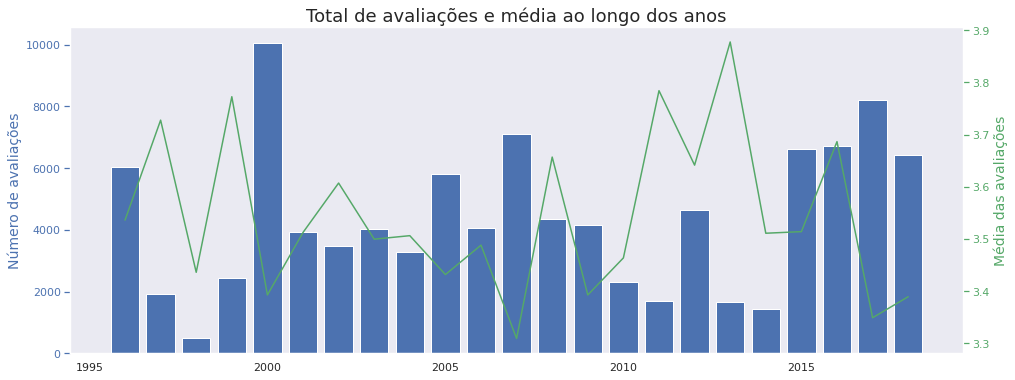

In [133]:
fig, ax = plt.subplots(figsize=(16,6))

# Gráfico de barras com o número de avaliações
ax.bar(ratings_timestamp.index.year, ratings_timestamp['Número de avaliações'])
ax.tick_params(axis="y", colors="b")
ax.set_ylabel("Número de avaliações", color="b", fontsize=14)
ax.grid(False)

ax2 = ax.twinx()
ax2.plot(ratings_timestamp.index.year, ratings_timestamp['Média das avaliações'], color="g")
ax2.tick_params(axis="y", colors="g")
ax2.set_ylabel("Média das avaliações", color="g", fontsize=14)
ax2.grid(False)
ax2.grid(False)


plt.title("Total de avaliações e média ao longo dos anos", fontsize=18)
plt.show()

Agrupando as avaliações por ano, também não conseguimos perceber **nenhuma tendência ou sazonalidade**.

Em termos de variação, o número de avaliações apresenta uma grande amplitude, com anos com pouco mais de 500 avaliações feitas e outros em que mais de 10 mil avaliações foram realizadas. A média das avaliações se apresenta um pouco mais homogênea, com menor amplitude (3,31 a 3,88).

A observação do gráfico acima parece indicar uma correlação entre o número anual de avaliações feitas e a média das avaliações naquele ano. Ou seja, parece que quanto mais avaliaçẽos feitas, menor é a média das avaliações. Vamos investigar isto melhor.

In [134]:
ratings_timestamp.corr()

,Média das avaliações,Número de avaliações
Média das avaliações,1.000000,-0.514578
Número de avaliações,-0.514578,1.000000


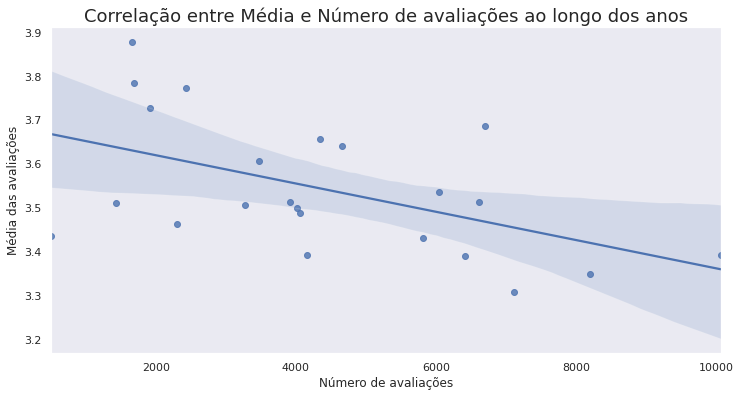

In [135]:
plt.figure(figsize=(12,6))

sns.regplot(data=ratings_timestamp, x='Número de avaliações', y='Média das avaliações')

plt.title('Correlação entre Média e Número de avaliações ao longo dos anos', fontsize=18)
plt.grid(False)
plt.show()

De fato o **coeficiente de correlação** e a **reta de regressão** mostram que existe uma tendência a médias de avaliação menores a medida em que o número de avaliações e maior.

## 5 - Qual é a correlação entre a avaliação e a criação de rótulos entre os usuários?

In [54]:
# Criando DF com a quantidade de rotulos criadas pro usuário
rating_tags = tags_df[['userId','tag']].groupby('userId').count()

# Criando coluna relacionando o userId com a quantidade de filmes avaliados
rating_tags['rating'] = ratings_df[['userId','rating']].groupby('userId').count()

# Visualizando o DF
rating_tags.head()

,tag,rating
userId,,
2,9,29
7,1,152
18,16,502
21,4,443
49,3,21


In [55]:
rating_tags.corr().round(2)

,tag,rating
tag,1.00,0.54
rating,0.54,1.00


Segundo a [Tabela do Coeficiente de Correlação de Pearson](https://pt.wikipedia.org/wiki/Coeficiente_de_correla%C3%A7%C3%A3o_de_Pearson), a correlação de 0,54 é considerada positiva moderada. 

## 6 - Como é a distribuição das notas em relação aos filmes?

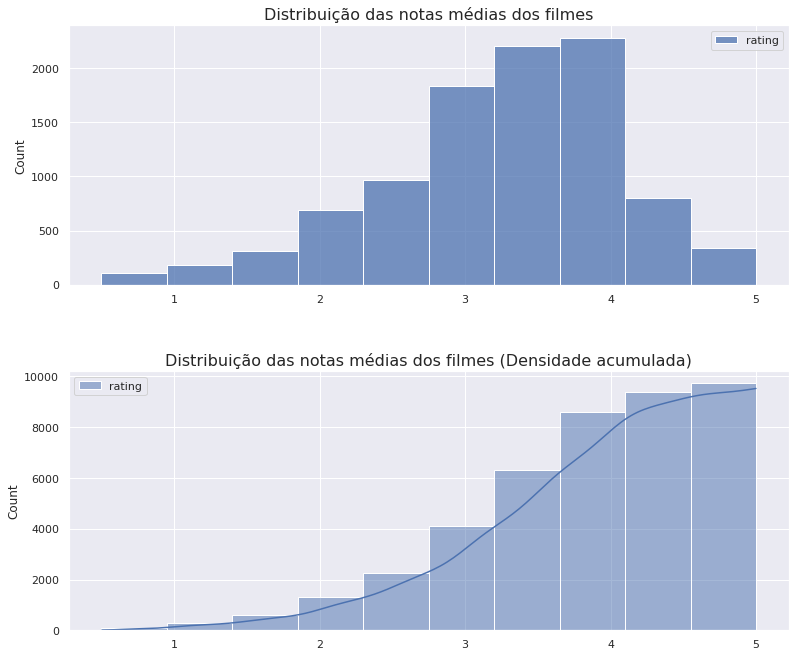

In [56]:
mean_rating = ratings_df[['movieId', 'rating']].groupby('movieId').mean().round(2)

fig = plt.figure(figsize=(10,8))

# Gráfico 1 - Histograma
eixo = fig.add_axes([0, 0.6, 1, 0.45])
eixo = sns.histplot(mean_rating, bins = 10)
eixo.set_title('Distribuição das notas médias dos filmes',fontsize = 16)

# Gráfico 2 - Notas Acumuladas
eixo2 = fig.add_axes([0, 0, 1, 0.45])
eixo2 = sns.histplot(mean_rating, kde = True, bins = 10, cumulative = True)
eixo2.set_title('Distribuição das notas médias dos filmes (Densidade acumulada)',fontsize = 16)

plt.show()

A nota média dos filmes se assemelha a uma curva assimétrica a esquerda, de modo que a maior parte das notas encontra-se entre 3 e 4. Notas médias abaixo de 2 a acima de 4,5 são menos comuns.

## 7 - Como é a distribuição dos filmes em relação ao ano de lançamento?

In [57]:
rating_medio_por_ano.head(3)

,ano,rating,count
0,1902.0,3.5,5
1,1903.0,2.5,2
2,1908.0,4.0,1


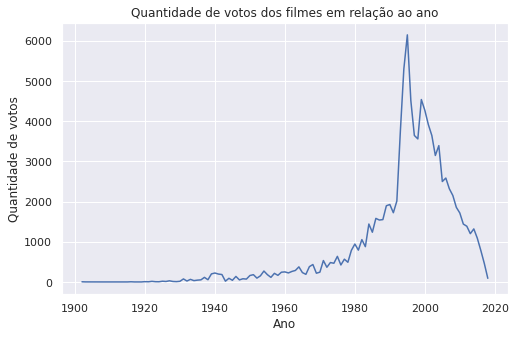

In [58]:
fig = plt.figure(figsize=(8,5))

#Gráfico de Linhas
ax = sns.lineplot(x = 'ano', y = 'count', data = rating_medio_por_ano)
ax.set(ylabel = 'Quantidade de votos', xlabel = 'Ano')
ax.set_title('Quantidade de votos dos filmes em relação ao ano')

plt.show()

As notas possuem uma semelhança comum uma distribuição assimétrica à esquerda, com o pico de notas referentes a filmes lançados nos anos 2000

## 8 - Existe uma correlação entre a nota dos filmes e a quantidade de tags?

In [59]:
# Criando DF que lista a nota média dos filmes com a quantidade de tags atribuidas a ele
mean_rating_tag = mean_rating.copy()
mean_rating_tag['tag'] = tags_df.groupby('movieId').count().tag
mean_rating_tag.dropna(inplace = True)
mean_rating_tag.head()

,rating,tag
movieId,,
1,3.92,3.0
2,3.43,4.0
3,3.26,2.0
5,3.07,2.0
7,3.19,1.0


In [60]:
mean_rating_tag.corr().round(3)

,rating,tag
rating,1.000,0.079
tag,0.079,1.000


O Coeficiente de correlação de Pearson é próximo de 0, ou seja, não existe uma correlação direta entre a nota média dos filmes e a quantidade de vezes que os usuários rotularam ele

## 9 - Filmes que se enquadram em mais generos são possuem uma avaliação melhor?

In [61]:
# Montando DF da quantidade de generos por filme
quantidade_de_generos = generos.sum(axis = 1)
movie_qtd_generos= pd.concat([movies_df, quantidade_de_generos], axis = 1)
movie_qtd_generos.rename(columns = {0:'Quantidade de Generos'}, inplace = True)
movie_qtd_generos.drop('genres', axis = 1, inplace = True)
movie_qtd_generos.set_index('movieId', inplace = True)
movie_qtd_generos.head()

,title,Quantidade de Generos
movieId,,
1,Toy Story (1995),5
2,Jumanji (1995),3
3,Grumpier Old Men (1995),2
4,Waiting to Exhale (1995),3
5,Father of the Bride Part II (1995),1


In [62]:
# Criando DF do rating médio por movieId
rating_medio_por_filme = ratings_df[['movieId','rating']].groupby('movieId').mean().round(2)

# Concatenando DF
movie_qtd_generos_e_rating = pd.concat([movie_qtd_generos, rating_medio_por_filme], axis = 1)
movie_qtd_generos_e_rating.head()

,title,Quantidade de Generos,rating
movieId,,,
1,Toy Story (1995),5,3.92
2,Jumanji (1995),3,3.43
3,Grumpier Old Men (1995),2,3.26
4,Waiting to Exhale (1995),3,2.36
5,Father of the Bride Part II (1995),1,3.07


In [63]:
movie_qtd_generos_e_rating.corr()

,Quantidade de Generos,rating
Quantidade de Generos,1.000000,0.000306
rating,0.000306,1.000000


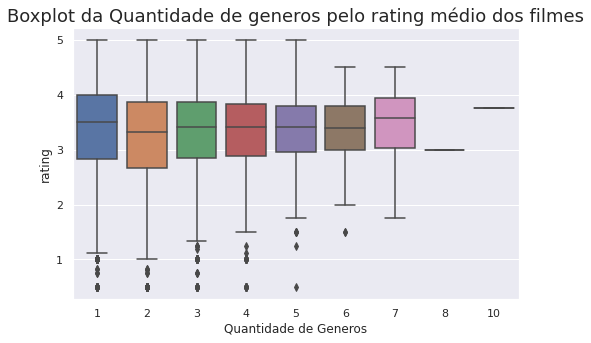

In [64]:
# Boxplot da Quantidade de generos pelo rating médio dos filmes
fig = plt.figure(figsize=(8,5))
ax = sns.boxplot(y = movie_qtd_generos_e_rating['rating'], x = movie_qtd_generos_e_rating['Quantidade de Generos'])
ax.set_title('Boxplot da Quantidade de generos pelo rating médio dos filmes', fontsize = 18)
plt.show()

Pelo valor do coeficiente de correlação e pela análise do Boxplot, a quantidade de generos do filme não afeta a nota dada pelo usuário

## 10 - Montar modelo de Clusterização para separar os filmes em 5 grupos em relação aos gêneros

In [65]:
# Separar os generos por colunas
generos = movies_df['genres'].str.get_dummies()

# Escalar os generos
from sklearn.preprocessing import StandardScaler
escalador = StandardScaler()
generos_escalados = escalador.fit_transform(generos)

# Clusterizar os filmes em 5 grupos
from sklearn.cluster import KMeans
modelo = KMeans(n_clusters = 5, random_state= 1234)
modelo.fit(generos_escalados)

# Montar um DF dos grupos com os centroids e em relação aos grupos
grupos = pd.DataFrame(modelo.cluster_centers_,
             columns = generos.columns).T
grupos  

,0,1,2,3,4
(no genres listed),-0.059195,-0.059195,0.041413,-0.059195,-0.059195
Action,0.336104,0.377689,-0.242748,0.768904,-0.104539
Adventure,-0.165170,0.038004,-0.176177,0.536754,0.911130
Animation,-0.240615,-0.204350,-0.251552,0.068511,2.186738
Children,-0.263983,-0.260059,-0.270526,-0.236942,2.719653
Comedy,-0.578821,-0.477883,0.244446,-0.431397,0.278882
Crime,0.838822,-0.294237,-0.151379,-0.290803,-0.314732
Documentary,-0.212255,-0.065118,0.138751,-0.212453,-0.211982
Drama,0.088094,0.680951,0.095928,-0.481058,-0.593404
Fantasy,-0.132783,-0.236539,-0.100589,0.149764,0.885468


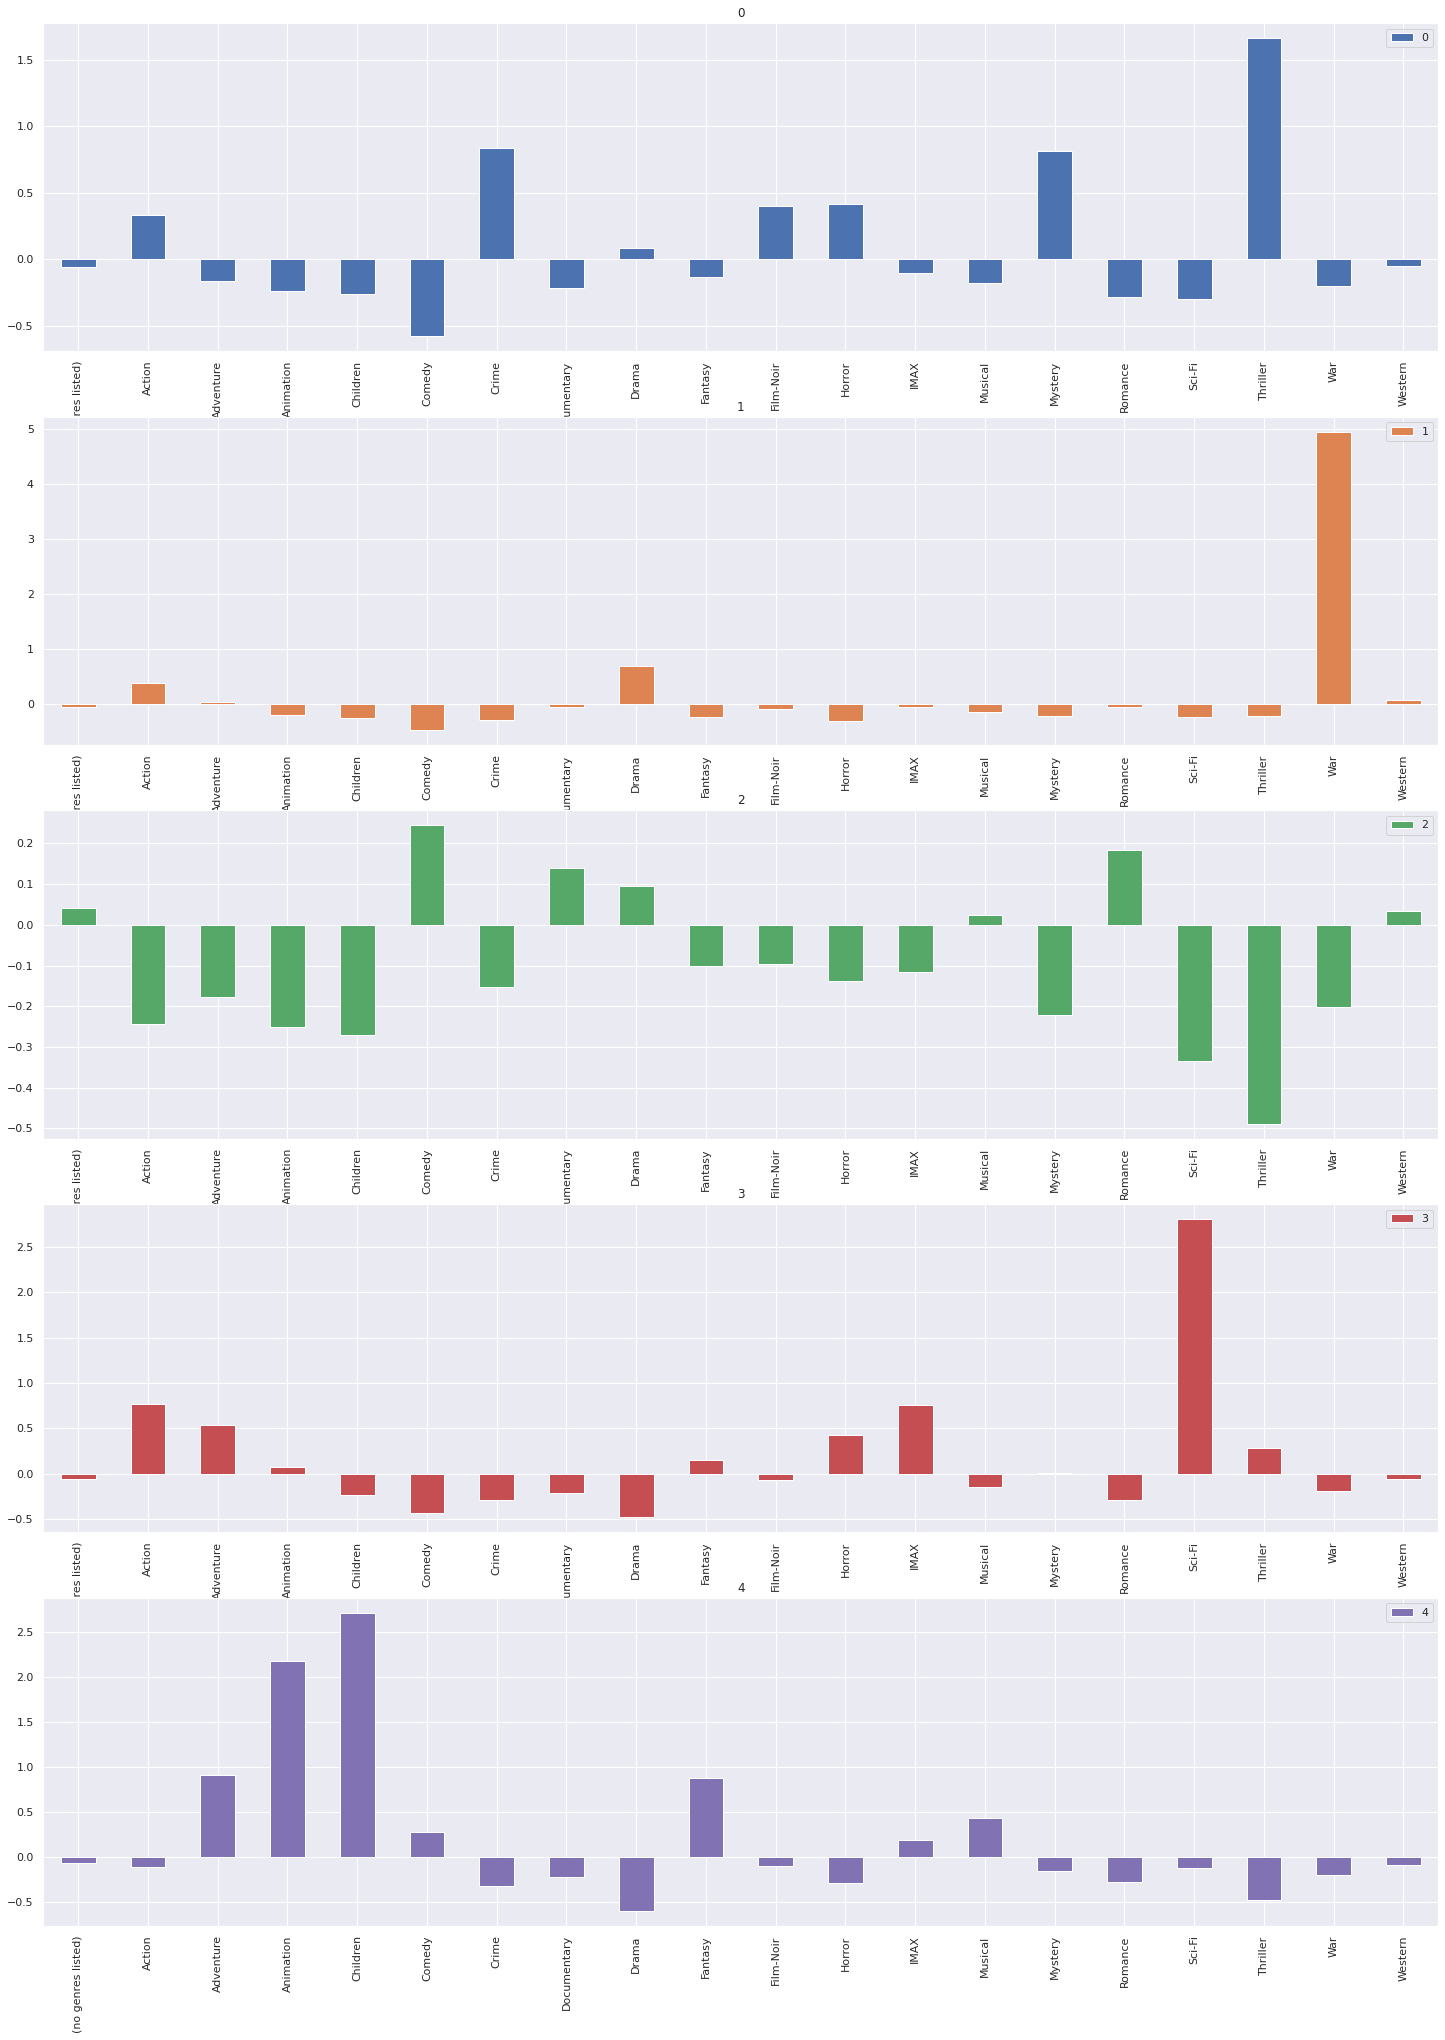

In [66]:
grupos.plot.bar(subplots = True, figsize = (25,35), sharex = False) 
plt.show()

Separando os generos dos filmes pelo KMeans em 5 grupos, pode-se definir os grupos da seguinte foram



> Grupo 0: Filmes de *Horror* com um pouco de *Thriller*

> Grupo 1: Filmes *Infantis* de *Animação*, com um pouco de *Aventura* e *Fantasia*

> Grupo 2: Filmes de *Romance*, com um pocuo de *Comédia* e *Drama*

> Grupo 3: *Documentários*

> Grupo 4: Filmes de *Ação*, *Crimes* e *Drama*
